<a href="https://colab.research.google.com/github/javohir-ergashboyev/tensorflow_basics/blob/main/Video_loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tqdm opencv-python remotezip
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done
  Created wheel for remotezip: filename=remotezip-0.12.2-py3-none-any.whl size=7890 sha256=6f26ad792dd14442eb230e8e4e0230480eee496431c0c41c795b4fe892d86783
  Stored in directory: /root/.cache/pip/wheels/f2/71/f9/c650cc34039d772da8b040ed447b6b5f5de9abc38d88073fa1
Successfully built remotezip
  Preparing metadata (setup.py) ... done


In [25]:
import tqdm
import random
import cv2
import remotezip
import pathlib
import collections
import itertools
import os
import imageio
import numpy as np
import tensorflow as tf
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

In [3]:
url= 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

In [8]:
def get_list_from_zip(zip_url):
  file_list=[]
  with remotezip.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      file_list.append(zip_info.filename)
  return file_list

In [9]:
file_list=get_list_from_zip(url)
files=[f for f in file_list if f.endswith('.avi')]
files[:10]


['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

In [10]:
def get_class(files):
  return files.split('_')[-3]

In [18]:
def get_file_per_class(file):
  file_dict=collections.defaultdict(list)
  for f in files:
    class_name=get_class(f)
    file_dict[class_name].append(f)
  return file_dict

In [17]:
NUM_CLASSES=10
FILES_PER_CLASS=50

In [19]:
files_for_classes=get_file_per_class(files)
classes=list(files_for_classes.keys())
len(classes), len(files_for_classes[classes[0]])

(101, 145)

In [20]:
def get_file_subset(files_per_class, classes, file_number):
  file_subset=dict()
  for class_name in classes:
      class_file=files_per_class[class_name]
      file_subset[class_name]=class_file[:file_number]
  return file_subset

In [22]:
file_subset=get_file_subset(files_for_classes, classes[:NUM_CLASSES],FILES_PER_CLASS )
len(file_subset.keys()),len(file_subset[classes[0]])

(10, 50)

In [30]:
def download_from_zip(zip_url, to_dir, file_names):
  with remotezip.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_names=get_class(fn)
      zip.extract(fn,str(to_dir/class_names))
      unzipped_file=to_dir/class_names/fn
      fn=pathlib.Path(fn).parts[-1]
      output_file=to_dir/class_names/fn
      unzipped_file.rename(output_file)

In [24]:
def split_remainder(files_for_classes, count):
  split_files=[]
  remainder={}
  for cls in files_for_classes:
    split_files.extend(files_for_classes[cls][:count])
    remainder[cls]=files_for_classes[cls][count:]
  return split_files, remainder


In [28]:
def download_ucf_subset(zip_url, num_classes, splits, download_dir):
  files=get_list_from_zip(zip_url)

  for f in files:
    path=os.path.normpath(f)
    tokens=path.split(os.sep)
    if len(tokens)<=2:
      files.remove(f)

    files_for_class=get_file_per_class(files)
    classes=list(files_for_classes.keys())[:num_classes]
    for cls in classes:
      random.shuffle(files_for_class[cls])
    files_for_class={x:files_for_class[x] for x in classes}

    dirs={}
    for split_name, split_count in splits.items():
      print(split_name,':')
      split_dir=download_dir/split_name
      split_file, files_for_class=split_remainder(files_for_class, split_count)
      download_from_zip(zip_url, split_dir, split_file)
      dirs[split_name]=split_dir
    return dirs

In [31]:
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ucf_subset(url,
                                  num_classes = NUM_CLASSES,
                                  splits = {"train": 30, "val": 10, "test": 10},
                                  download_dir = download_dir)

train :


100%|██████████| 300/300 [00:44<00:00,  6.70it/s]


val :


100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


test :


100%|██████████| 100/100 [00:13<00:00,  7.41it/s]


In [32]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 500


In [38]:
def format_frames(frame, output_size):
  frame=tf.image.convert_image_dtype(frame, tf.float64)
  frame=tf.image.resize_with_pad(frame, *output_size)
  return frame

In [39]:
def frames_from_video_file(video_path,n_frames, output_size=(224,224),frame_step=15):
  result=[]
  capture=cv2.VideoCapture(str(video_path))
  video_length = capture.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  capture.set(cv2.CAP_PROP_POS_FRAMES, start)

  ret, frame = capture.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = capture.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  capture.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result


In [35]:
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.0M  100 55.0M    0     0  24.2M      0  0:00:02  0:00:02 --:--:-- 24.2M


In [36]:
video_path = "End_of_a_jam.ogv"

In [40]:
sample_video = frames_from_video_file(video_path, n_frames = 10)
sample_video.shape

(10, 224, 224, 3)

In [41]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


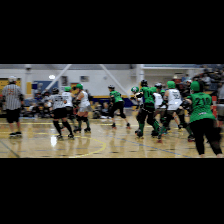

In [43]:
to_gif(sample_video)


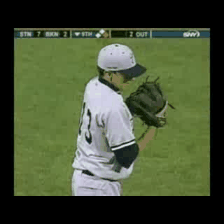

In [44]:
ucf_sample_video = frames_from_video_file(next(subset_paths['train'].glob('*/*.avi')), 50)
to_gif(ucf_sample_video)

In [45]:
class FrameGenerator:
    def __init__(self, path, n_frames, training=False):
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):
      video_paths = list(self.path.glob('*/*.avi'))
      classes = [p.parent.name for p in video_paths]
      return video_paths, classes

    def __call__(self):
      video_paths, classes = self.get_files_and_class_names()

      pairs = list(zip(video_paths, classes))

      if self.training:
        random.shuffle(pairs)

      for path, name in pairs:
        video_frames = frames_from_video_file(path, self.n_frames)
        label = self.class_ids_for_name[name] # Encode labels
        yield video_frames, label

In [46]:
fg = FrameGenerator(subset_paths['train'], 10, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 9


In [47]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10, training=True),
                                          output_signature = output_signature)

In [48]:
for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(9, shape=(), dtype=int16)
tf.Tensor(7, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(6, shape=(), dtype=int16)
tf.Tensor(3, shape=(), dtype=int16)
tf.Tensor(4, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)


In [49]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10),
                                        output_signature = output_signature)

In [50]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (10, 224, 224, 3)
Shape of training labels: ()
Shape of validation set of frames: (10, 224, 224, 3)
Shape of validation labels: ()


In [51]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [52]:
train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (2, 10, 224, 224, 3)
Shape of training labels: (2,)
Shape of validation set of frames: (2, 10, 224, 224, 3)
Shape of validation labels: (2,)


In [53]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(10),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

model.fit(train_ds,
          epochs = 10,
          validation_data = val_ds,
          callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'))

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/10
150/150 [==============================] - 27s 92ms/step - loss: 1.1331 - accuracy: 0.7000 - val_loss: 0.4900 - val_accuracy: 0.8800
Epoch 2/10
150/150 [==============================] - 9s 60ms/step - loss: 0.3149 - accuracy: 0.9733 - val_loss: 0.2818 - val_accuracy: 0.9400
Epoch 3/10
150/150 [==============================] - 9s 59ms/step - loss: 0.1681 - accuracy: 0.9967 - val_loss: 0.2001 - val_accuracy: 0.9700
Epoch 4/10
150/150 [==============================] - 9s 58ms/step - loss: 0.1037 - accuracy: 1.0000 - val_loss: 0.1580 - val_accuracy: 0.9700
Epoch 5/10
150/150 [==============================] - 9s 60ms/step - loss: 0.0734 - accuracy: 1.0000 - val_loss: 0.1425 - val_accuracy: 0.9600
Epoch 6/10
150/150 [==============================] - 9s 59ms/step - loss: 0.0537 - accuracy: 1.0000 - val_loss: 0.1296 - val_accuracy: 0.9700
Epoch 7/10
150/150 [==============================] - 9s 61ms/step - loss: 0